In [1]:
%matplotlib inline

In [120]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import scipy as sp

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

In [3]:
##Steps to discretize events##

#generate parameters with uniform_param_generator
#generate simulated event (Python dictionary obect) (COULD ADD NOISE HERE?)  - seems to make more sense during generation
#convert simulated events to Event objects
#write this to our h5

#load h5 file and give it to discretizatio function
#loop through all events in h5 discretizing by taking evt.xyzs (COULD ADD NOISE HERE?)
#save discretized events to sparse csr_matrix

In [4]:
with open('/home/taylor/Documents/independent-research/req-files/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']

gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 20

In [5]:
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [57]:
p = next(pgen)

#p[0][0] = -0.00791423
#p[0][1] =  0.0030299
#p[0][2] = 0.56803276
#p[0][3] = 1.83097548
#p[0][4] =  0.11137931
#p[0][5] =  2.01473709

print(p)

(array([ 0.0073989 , -0.00264504,  0.23299776,  1.1415614 ,  0.31621892,
        2.05069158]), array([ 0.00815722, -0.00291613, -0.99996248]))


In [58]:
sim = EventSimulator(config)

In [60]:
evt, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
print(len(evt))

196


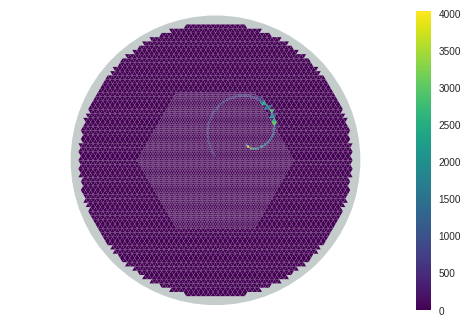

In [61]:
hits = np.zeros(10240)
for k, v in evt.items():
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

# Adding Random Noise

In [62]:
print(type(evt))

<class 'dict'>


In [63]:
print(evt.keys())

dict_keys([148, 149, 151, 441, 442, 443, 444, 445, 446, 448, 728, 729, 730, 731, 732, 733, 734, 735, 792, 793, 795, 798, 800, 801, 803, 806, 808, 811, 1012, 1013, 1014, 1015, 1016, 1071, 1073, 1074, 1075, 1077, 1078, 1080, 1093, 1094, 1096, 1099, 1101, 1102, 1103, 1105, 1106, 1286, 1288, 1289, 1290, 1291, 1383, 1384, 1386, 1388, 1389, 1390, 1557, 1558, 1559, 1560, 1561, 1562, 1661, 1663, 1664, 1665, 1822, 1823, 1824, 1825, 1826, 1827, 1928, 1930, 1931, 1932, 1933, 1934, 2081, 2082, 2083, 2084, 2085, 2086, 2190, 2191, 2192, 2193, 2194, 2334, 2335, 2336, 2337, 2338, 2441, 2442, 2443, 2580, 2581, 2582, 2583, 2584, 2585, 2587, 2683, 2684, 2820, 2822, 2823, 2824, 2825, 2826, 2827, 2829, 2918, 2919, 3054, 3056, 3057, 3058, 3059, 3060, 3061, 3063, 3144, 3145, 3146, 3281, 3284, 3286, 3287, 3288, 3290, 3291, 3362, 3363, 3364, 3365, 3506, 3507, 3509, 3510, 3511, 3512, 3513, 3516, 3518, 3574, 3575, 3721, 3724, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3736, 3738, 3739, 3741, 3762, 3763, 376

In [64]:
#print(evt.get(148))

In [65]:
pyevt = sim.convert_event(evt)

In [66]:
print(pyevt)

Event 0, timestamp 0.
Contains 196 traces.


In [67]:
print(type(pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)))

<class 'numpy.ndarray'>


In [68]:
xyzs = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
print(len(xyzs))
print(xyzs.shape)
print(xyzs)

196
(196, 5)
[[ -2.45411757e+00   7.05056055e+00   6.00000007e+01   4.58878870e+01
    1.48000000e+02]
 [  1.37667655e-14   5.70140844e+00   6.00000010e+01   1.49623137e+01
    1.49000000e+02]
 [  2.45411757e+00   7.05056055e+00   6.00000010e+01   1.49623137e+01
    1.51000000e+02]
 [ -7.36235272e+00   1.55518732e+01   5.89754519e+01   2.05824215e+02
    4.41000000e+02]
 [ -4.90823515e+00   1.42027211e+01   5.90322115e+01   7.22386416e+02
    4.42000000e+02]
 [ -4.90823515e+00   1.13012169e+01   5.95000320e+01   7.56129012e+01
    4.43000000e+02]
 [ -2.45411757e+00   1.55518732e+01   5.90253571e+01   2.47451102e+02
    4.44000000e+02]
 [ -2.45411757e+00   9.95206476e+00   5.99599688e+01   6.12799973e+02
    4.45000000e+02]
 [  1.37667655e-14   1.13012169e+01   5.99540883e+01   2.11900510e+02
    4.46000000e+02]
 [  2.45411757e+00   9.95206476e+00   6.00000010e+01   1.49623137e+01
    4.48000000e+02]
 [ -1.22705879e+01   2.40531859e+01   5.79280693e+01   2.98058950e+01
    7.28000000e+0

In [69]:
#noise requirements:
#x and y: -DETECTOR_RADIUS < __ < +DETECTOR_RADIUS
#z: 0 < __ < DETECTOR_LENGTH

DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

In [70]:
#add new noise, not just randomly osciallate existing points - np.random.___()

In [71]:
num_noisepts = np.random.randint(20, 300,)    #20-300
print(num_noisepts)

191


In [72]:
#generate x and y based on random pad numbers
paddresses = np.random.randint(0,10240, (num_noisepts, 1))
print(paddresses.shape)

pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

xys = pcenters[paddresses].reshape(num_noisepts, 2)
print(xys.shape)
#z and charge values are generated randomly in realistic ranges
zs = np.random.uniform(0, DETECTOR_LENGTH, (num_noisepts, 1))
print(zs.shape)

charges = np.random.uniform(1, 4000, (num_noisepts, 1))  #1-4000
print(charges.shape)

(191, 1)
(191, 2)
(191, 1)
(191, 1)


In [73]:
#note in discretization we do not need to return the pad addresses
noise_mat = np.hstack((xys, zs, charges, paddresses))

In [74]:
print(noise_mat)

[[  4.90823515e+01  -7.08104055e+01   8.24882445e+02   5.61478362e+02
    7.50800000e+03]
 [  1.96329406e+01   1.30319594e+02   9.32290547e+02   3.21220928e+03
    3.92300000e+03]
 [ -1.71788230e+01   2.69546901e+01   8.39806656e+02   2.67332810e+03
    1.00800000e+03]
 [  4.41741163e+01  -9.07145350e+01   1.51238369e+02   1.80007756e+02
    7.98700000e+03]
 [ -4.66282339e+01  -2.40531859e+01   7.18177854e+02   2.36493965e+03
    5.81900000e+03]
 [ -2.45411757e+01   1.30319594e+02   2.98314596e+02   2.97397744e+03
    3.88800000e+03]
 [ -6.62611745e+01  -3.25544985e+01   9.23069438e+02   3.68817877e+03
    6.08900000e+03]
 [ -7.36235272e+01   2.40904392e+02   4.51664554e+02   3.60094869e+03
    4.97100000e+03]
 [  6.87152921e+01  -1.64392578e+02   4.95941147e+02   6.90139984e+02
    9.46300000e+03]
 [ -4.90823515e+01  -6.52105970e+01   8.12252829e+02   6.93827393e+02
    7.17600000e+03]
 [  8.34399975e+01   1.42027211e+01   8.52823094e+00   5.53739441e+02
    5.14000000e+02]
 [ -4.1719

In [75]:
clean_xyzs = xyzs
noise_xyzs = np.vstack((xyzs, noise_mat))

In [76]:
print(clean_xyzs.shape)
print(noise_xyzs.shape)

(196, 5)
(387, 5)


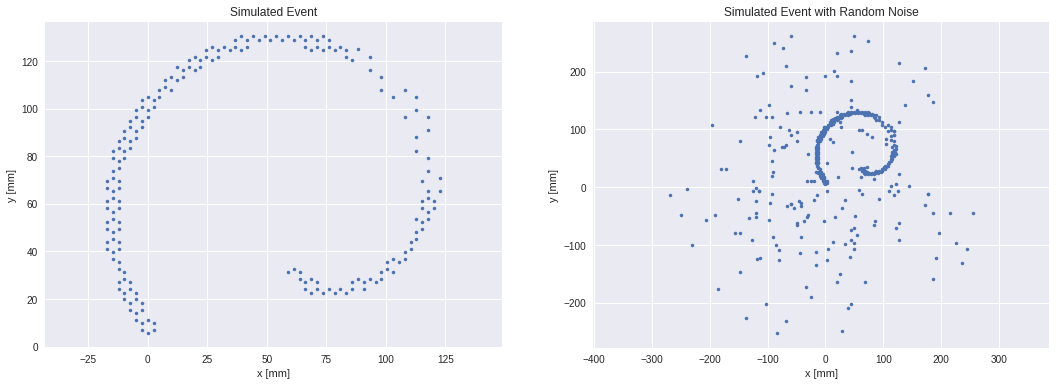

In [77]:
clean_xyzsclean_xyzsfig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

ax[0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0].axis('equal')
        
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title('Simulated Event')

#######################################################################################################################
ax[1].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1].axis('equal')
        
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title('Simulated Event with Random Noise')

# Compare to discretized

In [129]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

x_disc = 20
y_disc = 20
z_disc = 20

discElements = x_disc*y_disc*z_disc

x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [138]:
discretized_dataClean = np.zeros((1, discElements))
discretized_xyzClean = np.zeros([clean_xyzs.shape[0], clean_xyzs.shape[1]])

num_pts = 0

for point in clean_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0        
    
#     if(discretized_dataClean[0, bucket_num] == 1):
#         print("Duplicate Found")
#         discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
#     else:
    discretized_dataClean[0,bucket_num] = 1                  
    discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataClean.sum()))

buckets filled: 19.0


In [139]:
discretized_dataNoise = np.zeros((1, discElements))
discretized_xyzNoise = np.zeros([noise_xyzs.shape[0], noise_xyzs.shape[1]])

num_pts = 0

for point in noise_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    discretized_dataNoise[0,bucket_num] = 1

    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
        
    discretized_xyzNoise[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataNoise.sum()))

buckets filled: 203.0


In [140]:
print(discretized_xyzClean)
#discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((discretized_xyzClean), shape=(1, discElements))

[[  -13.75          13.75          75.            45.88788698   148.        ]
 [   13.75          13.75          75.            14.96231368   149.        ]
 [   13.75          13.75          75.            14.96231368   151.        ]
 [  -13.75          13.75          75.           205.82421462   441.        ]
 [  -13.75          13.75          75.           722.38641635   442.        ]
 [  -13.75          13.75          75.            75.61290119   443.        ]
 [  -13.75          13.75          75.           247.45110214   444.        ]
 [  -13.75          13.75          75.           612.79997271   445.        ]
 [   13.75          13.75          75.           211.90050972   446.        ]
 [   13.75          13.75          75.            14.96231368   448.        ]
 [  -13.75          13.75          75.            29.80589497   728.        ]
 [  -13.75          13.75          75.           550.22959934   729.        ]
 [  -13.75          13.75          75.            77.7321749    

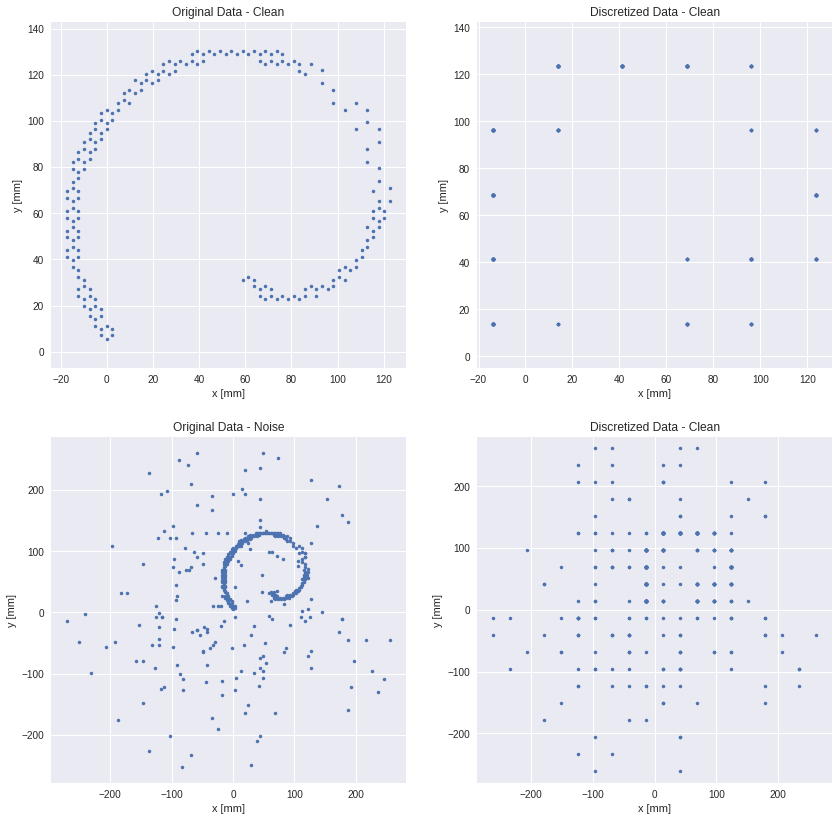

In [147]:
fig, ax = plt.subplots(2, 2, squeeze=True, figsize=(14, 14))

ax[0][0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0][0].axis('equal')
        
ax[0][0].set_xlabel('x [mm]')
ax[0][0].set_ylabel('y [mm]')
ax[0][0].set_title('Original Data - Clean')

#######################################################################################################################
ax[0][1].plot(discretized_xyzClean[:,0], discretized_xyzClean[:,1], '.')
ax[0][1].axis('equal')
        
ax[0][1].set_xlabel('x [mm]')
ax[0][1].set_ylabel('y [mm]')
ax[0][1].set_title('Discretized Data - Clean')

#######################################################################################################################
ax[1][0].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1][0].axis('equal')
        
ax[1][0].set_xlabel('x [mm]')
ax[1][0].set_ylabel('y [mm]')
ax[1][0].set_title('Original Data - Noise')

#######################################################################################################################
ax[1][1].plot(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], '.')
ax[1][1].axis('equal')
        
ax[1][1].set_xlabel('x [mm]')
ax[1][1].set_ylabel('y [mm]')
ax[1][1].set_title('Discretized Data - Clean')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparisonXY.pdf')

In [142]:
ch_colors = sns.cubehelix_palette(n_colors=6, start=0, rot=-0.4,
                                  gamma=1, hue=1, light=0.75, dark=0.1)
ch_cm = sns.blend_palette(ch_colors, as_cmap=True)

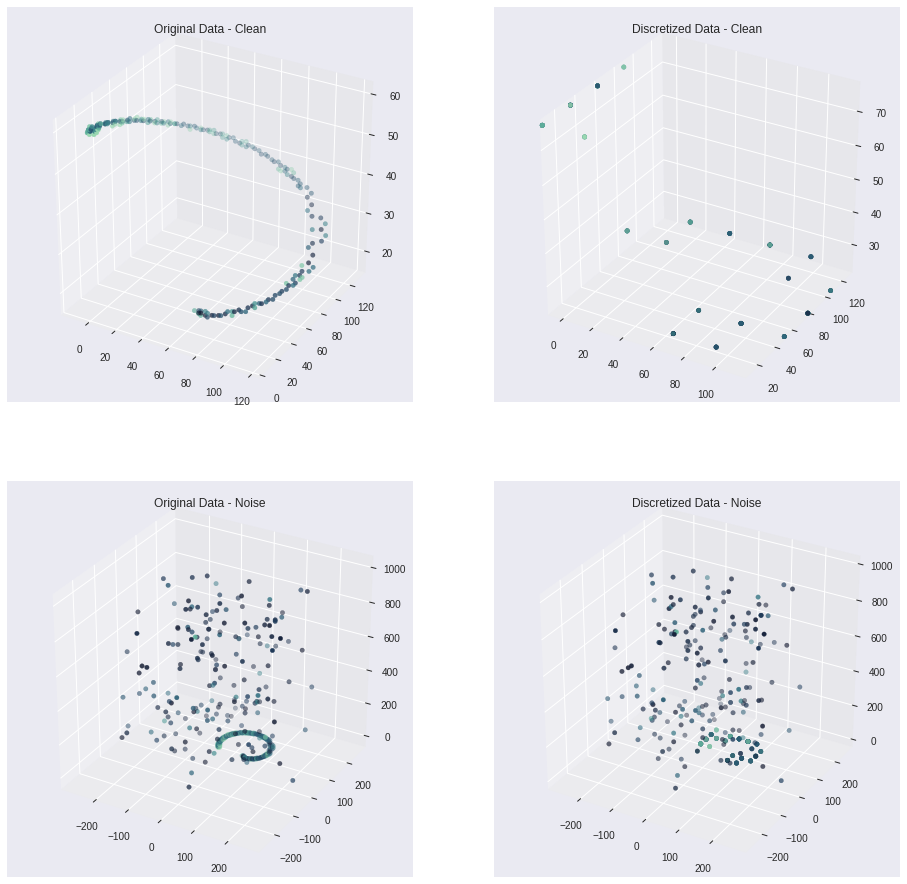

In [146]:
fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(clean_xyzs[:,0], clean_xyzs[:,1], clean_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=clean_xyzs[:,3])
ax.axis('equal')
ax.set_title("Original Data - Clean")

#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyzClean[:,0], discretized_xyzClean[:,1], discretized_xyzClean[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzClean[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Clean')

#######################################################################################################################
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter(noise_xyzs[:,0], noise_xyzs[:,1], noise_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=noise_xyzs[:,3])
ax.axis('equal')
ax.set_title('Original Data - Noise')

############################clean_xyzs###########################################################################################
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], discretized_xyzNoise[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzNoise[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Noise')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparison3D.pdf')

# pad num -> xy

In [86]:
nums = np.random.randint(0,10240, (num_noisepts, 1))

In [87]:
pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

In [88]:
xys = pcenters[nums]

In [89]:
print(xys)

[[[  9.32564678e+01   3.12053464e+01]]

 [[ -2.20870582e+02   1.16353940e+02]]

 [[  5.39905866e+01   6.23090928e+01]]

 [[ -1.47247054e+02   1.13384702e+02]]

 [[ -1.42338819e+02   3.68728882e+01]]

 [[  2.50319993e+02  -4.83434384e+01]]

 [[  2.45411757e+02  -9.08500016e+01]]

 [[ -1.57063525e+02   2.09868379e+02]]

 [[ -3.43576460e+01   1.55891265e+02]]

 [[  1.86512936e+02   1.13384702e+02]]

 [[ -4.66282339e+01  -9.95206476e+00]]

 [[  8.34399975e+01   1.67361816e+02]]

 [[ -6.13529394e+01   8.35623744e+01]]

 [[  2.45411757e+00  -1.55518732e+01]]

 [[ -2.35595287e+02  -1.07852627e+02]]

 [[  1.47247054e+01   6.52105970e+01]]

 [[ -2.15962347e+02  -1.24855252e+02]]

 [[ -1.15343526e+02  -1.55518732e+01]]

 [[ -8.83482327e+01   9.92158476e+01]]

 [[  2.45411757e+00  -3.54560027e+01]]

 [[  6.38070569e+01   2.79990422e+00]]

 [[  1.71788230e+02   1.04883389e+02]]

 [[ -2.45411757e+01  -3.68051548e+01]]

 [[ -4.90823515e+00   5.38077801e+01]]

 [[  1.52155290e+02   6.53460637e+01]]



In [90]:
print(xys.reshape(xys.shape[0], 2).shape)

(191, 2)
